# Traffic Forecasting with Pytorch Geometric Temporal


## Installation

In [ ]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic 
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network


In [3]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

print("Dataset type:  ", dataset)
#print("Number of samples / sequences: ",  len(set(dataset)))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f2db93f6390>


#### Data Sample
- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min) 
- Labels for 12 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between sensors + threshold
- Further details: https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader
- Raw data: https://graphmining.ai/temporal_datasets/METR-LA.zip

In [4]:
# Show first sample
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

METR-LA would be a sequence-to-sequence prediction dataset that predicts further into the future than just the next timestep. You can also see, that the features are used as label as well.



```
# >>> From METRLADatasetLoader <<<
indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]
for i, j in indices:
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in : j]).numpy())
```



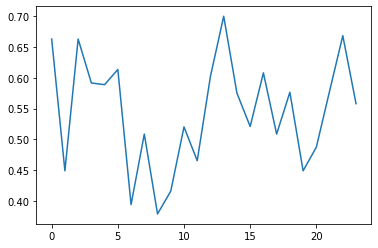

In [6]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

In [ ]:
batch = np.linspace(0,34250,172)
batch

In [ ]:
#dataset1 = StaticGraphTemporalSignalBatch(edge_index=dataset.edge_index,edge_weight=dataset.edge_weight,features=dataset.features, targets=dataset.targets,batches=batch)

#### Test Train Split

In [7]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

#print("Number of train buckets: ", len(set(train_dataset)))
#print("Number of test buckets: ", len(set(test_dataset)))

## Model

- A3TGCN is an extension of TGCN that uses attention 
- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future = output dimension
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=64, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear1 = torch.nn.Linear(64,64)
        self.linear2 = torch.nn.Linear(64, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 64)
      (linear_z): Linear(in_features=128, out_features=64, bias=True)
      (conv_r): GCNConv(2, 64)
      (linear_r): Linear(in_features=128, out_features=64, bias=True)
      (conv_h): GCNConv(2, 64)
      (linear_h): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=12, bias=True)
)

## Training

- Training on GPU didn't bring much speed-up
- I ran into RAM issues, why I only train on a smaller subset of the data

In [ ]:
# GPU support
device = torch.device('cpu') # cuda
subset = 1000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(100): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0 train MSE: 0.6433
Epoch 1 train MSE: 0.6133
Epoch 2 train MSE: 0.5745
Epoch 3 train MSE: 0.5304
Epoch 4 train MSE: 0.5189
Epoch 5 train MSE: 0.4925
Epoch 6 train MSE: 0.4585
Epoch 7 train MSE: 0.4383
Epoch 8 train MSE: 0.4234
Epoch 9 train MSE: 0.4104
Epoch 10 train MSE: 0.4109
Epoch 11 train MSE: 0.4208
Epoch 12 train MSE: 0.4167
Epoch 13 train MSE: 0.4019
Epoch 14 train MSE: 0.3913
Epoch 15 train MSE: 0.3882
Epoch 16 train MSE: 0.3882
Epoch 17 train MSE: 0.3893
Epoch 18 train MSE: 0.3913
Epoch 19 train MSE: 0.3922
Epoch 20 train MSE: 0.3895
Epoch 21 train MSE: 0.3848
Epoch 22 train MSE: 0.3809
Epoch 23 train MSE: 0.3782
Epoch 24 train MSE: 0.3763
Epoch 25 train MSE: 0.3760
Epoch 26 train MSE: 0.3759
Epoch 27 train MSE: 0.3737
Epoch 28 train MSE: 0.3703
Epoch 29 train MSE: 0.3680
Epoch 30 train MSE: 0.3672
Epoch 31 train MSE: 0.3673
Epoch 32 train MSE: 0.3678
Epoch 33 train MSE: 0.3675
Epoch 34 train MSE: 0.3661
Epoch 35 train MSE: 0.3648
Epoch 36 train MSE

## Evaluation

- sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
- The model always gets one hour and needs to predict the next hour

In [ ]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [ ]:
import numpy as np

sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")